### Count regression

This notebook demonstrates the use of TFP for regression on count data. The dataset is the number of fish caught in a state park. 

* Poisson Regression
* Zero Infated Poisson Regression



In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install tfp-nightly
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


### Creating some count data

This is just to demonstrate how to use TF distributions for a Poisson distribution, with given parameters. Below we learn the paramters. 

2.0
1.4142135


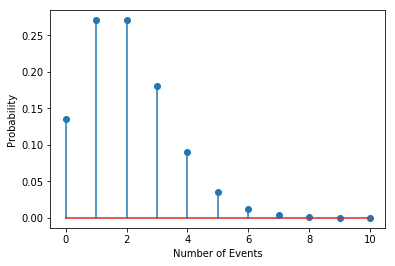

In [3]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
dist = tfd.poisson.Poisson(rate = 2) #A
vals = np.linspace(0,10,11) #B
p = dist.prob(vals) #C
print(dist.mean().numpy())  #D
print(dist.stddev().numpy())   #E

plt.stem(vals, p)
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.savefig('ch05_rain.pdf')

#A Poisson distribution with parameter rate 2
#B some values for the x-axis in figure 5.rain
#C the probability for the values
#D the mean value yielding 2.0
#E the standard deviation yielding sqrt(2.0) = 1.41...

## Loading some count data

We use some traditional count data from: https://stats.idre.ucla.edu/r/dae/zip/. The number fish caught during a state park visit.

In [4]:
# Alternative version
# dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/nb_data.csv') 
# X = dat[...,0:3]
# y = dat[...,4]
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)
# X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

In [5]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
#dat = np.loadtxt('../data/fish.csv', delimiter=',', skiprows=1)
dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv',delimiter=',', skiprows=1)
X = dat[...,1:5] #"livebait","camper","persons","child
y = dat[...,7]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)
d = X_tr.shape[1]
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape,dat.shape

((167, 4), (167,), (83, 4), (83,), (250, 8))

149.0

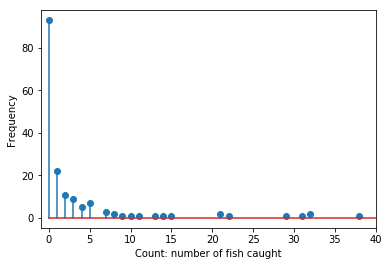

In [6]:
vals, counts = np.unique(y_tr, return_counts=True)
plt.stem(vals, counts)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.xlim(-1,40)
plt.savefig('ch05_school.pdf')
np.max(y_tr)

## 1 Doing linear regression

In this section we do a standard linear regression.

In [7]:
model_lr = tf.keras.Sequential() #A
model_lr.add(tf.keras.layers.Dense(1,input_dim=d, activation='linear')) #B 
model_lr.compile(loss='mean_squared_error',optimizer=tf.optimizers.Adam(learning_rate=0.01))

In [8]:
hist_lr = model_lr.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=600, verbose=False);
#hist_lr = model_lr.fit(x=X_tr, y=np.sqrt(y_tr), validation_data=(X_te, y_te), epochs=600, verbose=False);

143.1899229527061

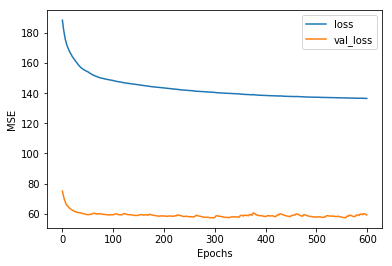

In [9]:
plt.plot(hist_lr.history['loss'])
plt.plot(hist_lr.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
np.mean(hist_lr.history['loss'])

In [10]:
y_hat_te = model_lr.predict(X_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te)) #(8.540011535073502, 6.001939873018208)
#np.sqrt(np.mean((y_hat_te**2 - y_te)**2)),np.mean(np.abs(y_hat_te**2 - y_te)) #(8.540011535073502, 6.001939873018208)

(9.621143856502835, 6.027080499065132)

Text(0, 0.5, 'Predicted ')

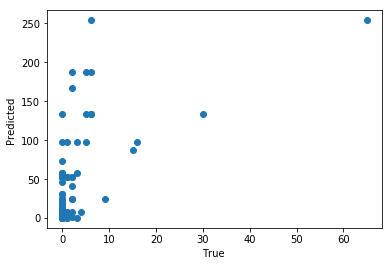

In [11]:
plt.scatter(y_te, y_hat_te**2)
plt.xlabel('True ')
plt.ylabel('Predicted ')

## 2 Doing Poisson Regression

#### Definition of the Model

$$
    Y \thicksim \tt{Pois}(exp(w^{T} \cdot x + b))
$$

In [12]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
rate = tf.keras.layers.Dense(1, 
         activation=tf.exp, #A
         bias_initializer='zeros', 
         kernel_initializer='zeros')(inputs)
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) #B 

model_p = Model(inputs=inputs, outputs=p_y) #C


def negloglik(y_true, y_hat): #D
  return -y_hat.log_prob(y_true)

model_p.compile(tf.optimizers.Adam(learning_rate=0.01), 
                loss=negloglik)

#A Definition of a single layer with one output
#B We use exponential of the output to model the rate
#C Glueing input and output together. Note that output is a tf.distribution
#D Since the second argument is the output of the model it is a distribution. It's as simple as calling log_prob to calculate the NLL.

In [13]:
hist_p = model_p.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=2000, verbose=False);

(0, 5)

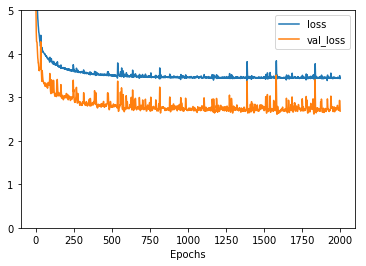

In [14]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
np.mean(hist_p.history['loss'])
plt.ylim(0,5)

In [15]:
model_pm = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) 
y_hat_te = model_pm(X_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te))

(9.662406, 4.595026)

Training Set 2.3400428 59
Validation Set 5.050113 36


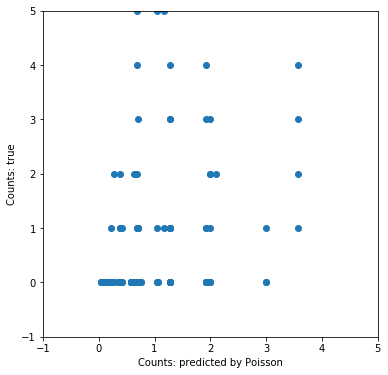

In [16]:
plt.figure(figsize=(6,6))
plt.xlim(-1,5)
plt.ylim(-1,5)
y_hat_tr = model_pm(X_tr)
plt.scatter(y_hat_tr, y_tr)
plt.xlabel('Counts: predicted by Poisson')
plt.ylabel('Counts: true')
plt.savefig('ch05_pois.pdf')
print('Training Set', np.mean(np.square(y_hat_tr[y_tr == 0])),np.sum(y_hat_tr[y_tr == 0]>0.5))
print('Validation Set', np.mean(np.square(y_hat_te[y_te == 0])),np.sum(y_hat_te[y_te == 0]>0.5))

## 3 Using zero inflated Poisson Regression

We define a network with two outputs. One for the poisson mean, one for the prob that there is a zero. 

First, we define a function which produces the zero inflated poisson distribution. 

### Definition of the distribution

In [17]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
# Listing 5.l_zi
def zero_inf(out): 
    rate = tf.math.exp(out[:,0]) #A 
    #rate = tf.math.softplus(out[:,0]) #A 
    s = tf.math.sigmoid(out[:,1:]) #B  
    probs = tf.concat([s, 1-s], axis=1) #C 
    print(np.min(rate), " ", np.max(rate), " ", np.min(s), np.max(s),"  ",np.min(out[:,1:]), np.max(out[:,1:]))
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
            tfd.Deterministic(loc=tf.zeros_like(rate)), #E
            tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We use exponential to guaranty values >0.
#B The second component codes for the zero inflation, using sigmoid squeezes the value between 0 and 1.
#C The two probabilities for zeros or Poissonian  
#D The tfd.Categorical allows to create a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian

In [18]:
## testinging the distribution
t = np.ones((5,2), dtype=np.float32)
t[4,0]=0.999
t[4,1]=10
zero_inf(t).mean()

W0615 16:00:12.846740 140131559577344 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


2.715565   2.7182817   0.7310586 0.9999546    1.0 10.0


<tf.Tensor: id=133932, shape=(5,), dtype=float32, numpy=
array([7.3105848e-01, 7.3105848e-01, 7.3105848e-01, 7.3105848e-01,
       1.2333754e-04], dtype=float32)>

### Definition of the model

In [19]:
## Definition of the model
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
## Definition of the custom parametrized distribution
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
out = Dense(2,  #A
            kernel_regularizer=l2(0.01), #B
            bias_regularizer=l2(0.01))(inputs)#B
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

#A A dense layer is used without activation. The transformation is done in zero_inf listing 5.l_zi 
#B Using a regularisation prevents the network from learning too large weights. Without regularisation, you run into numerical problems.
model_zi.summary()

Tensor("distribution_lambda_1/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_1/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_1/Sigmoid:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_1/Sigmoid:0", shape=(None, 1), dtype=float32)    Tensor("distribution_lambda_1/strided_slice_2:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_1/strided_slice_3:0", shape=(None, 1), dtype=float32)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
distribution_lambda_1 (Distr ((None,), (None,))        0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
____

### Training of the model (by hand) [optional]

The following code trains the NN using a evaluation loop by hand. This help us to find instabilities, which we got rid off using regularisation. See also: https://www.tensorflow.org/beta/guide/keras/training_and_evaluation#part_ii_writing_your_own_training_evaluation_loops_from_scratch


In [20]:
optimizer=tf.optimizers.RMSprop(learning_rate=0.05)
loss_values = np.zeros((1000))
for e in range(10):
    with tf.GradientTape() as tape:
        y_hat = model_zi(X_tr)
        loss_value = -tf.reduce_mean(y_hat.log_prob(y_tr))
        loss_values[e] = loss_value
        grads = tape.gradient(loss_value, model_zi.trainable_weights)
        weights =  model_zi.trainable_weights       
        optimizer.apply_gradients(zip(grads,weights))

1.5877341   319.73492   0.5642597 0.99010235    0.25846815 4.605508
1.157289   65.782486   0.40757802 0.9601698    -0.37398666 3.182485
1.2279294   73.21793   0.32440627 0.91858107    -0.73359525 2.423222
1.2622817   71.15734   0.28375754 0.89738476    -0.92589855 2.168498
1.2806373   65.62024   0.26388985 0.89217305    -1.025848 2.1131322
1.2942808   59.804256   0.25323483 0.89752483    -1.0814335 2.17002
1.3063785   54.44418   0.24727038 0.90427566    -1.1132238 2.2456615
1.317498   49.59755   0.2441755 0.9106904    -1.1299219 2.3220944
1.3277122   45.219006   0.24306262 0.9163737    -1.1359615 2.394066
1.3370327   41.25933   0.24342255 0.9212973    -1.134006 2.4601045


### Training using keras' build in training

In [21]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik2)
hist_zi = model_zi.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=2000, verbose=False)#, callbacks=[tb]);

(2.747347429743732, 2.532076622858105)

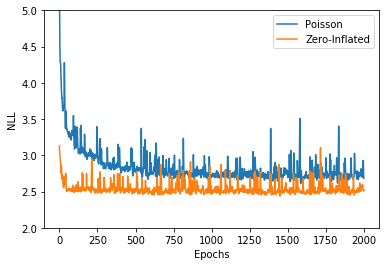

In [22]:
#plt.plot(hist_p.history['loss'],linestyle='-.')
plt.plot(hist_p.history['val_loss'])
#plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.ylim(2,5)
#plt.legend(['Poisson loss','Poisson val_loss','ZI loss','ZI val_loss'])
plt.legend(['Poisson','Zero-Inflated'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.savefig('ch05_flik.pdf')
np.mean(hist_p.history['val_loss'][1000:]) ,np.mean(hist_zi.history['val_loss'][1000:]) 

In [23]:
model_zi = tf.keras.models.Model(inputs=inputs, outputs=p_y_zi.mean())
y_hat_te = model_zi(X_te)
#mean_absolute_error(y_hat_te, y_te), mean_squared_error(y_hat_te, y_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te))

(6.522155, 3.2028606)

Training Set 2.658758 61
Validation Set 5.7189765 38


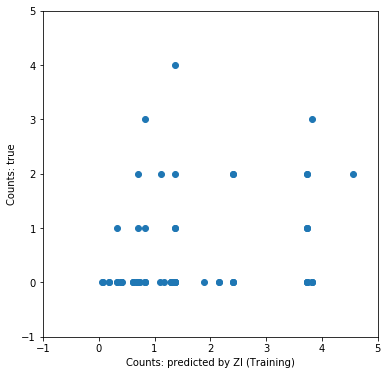

In [24]:
plt.figure(figsize=(6,6))
plt.xlim(-1,5)
plt.ylim(-1,5)
y_hat_tr = model_zi(X_tr)
plt.scatter(y_hat_te, y_te)
plt.xlabel('Counts: predicted by ZI (Training)')
plt.ylabel('Counts: true')

plt.savefig('ch05_zi.pdf')
print('Training Set', np.mean(np.square(y_hat_tr[y_tr == 0])),np.sum(y_hat_tr[y_tr == 0]>0.5))
print('Validation Set', np.mean(np.square(y_hat_te[y_te == 0])),np.sum(y_hat_te[y_te == 0]>0.5))